In [27]:
import sys

sys.path.append("../")

In [28]:
import torch
import torch.distributions as dist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from full_pipeline_main import generate_dataset
from models import SDCI
from utils import create_intervention_dataset, subset_interventions

In [29]:
import os
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [30]:
seed = 0
n, d = 100, 20
n_edges_per_d = 2
frac_interventions = 1.0

def scale_fn(depth, plateau_depth = 17, slope = 15):
    return (max(1, plateau_depth - depth) / plateau_depth) * slope

X_df, B_true, wandb_config_dict = generate_dataset(
    n, d, seed, frac_interventions, n_edges_per_d=n_edges_per_d# , scale=scale_fn
)
X_obs = X_df[X_df["perturbation_label"] == "obs"].loc[:, np.arange(d)].to_numpy()
X_sub_df = subset_interventions(
    X_df, d, maintain_dataset_size=True
)

In [31]:
X_df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,perturbation_label
0,-2.232801,-0.126695,12.573777,-2.446837,9.431922,11.964704,6.207593,-3.130709,-6.929017,7.397964,...,1.388225,2.498680,-1.349603,10.903043,-7.469987,-8.599607,-4.312869,-0.562920,-0.595159,obs
1,-3.032671,0.026483,13.792112,-1.849876,7.775031,10.191050,4.655273,-3.461518,-5.741735,6.014399,...,-1.872937,0.516561,-0.079112,7.731908,10.348013,-7.250196,-3.187666,-0.576180,-0.425593,obs
2,1.727478,0.828363,14.335428,-1.883785,5.663759,0.820017,-4.030437,-8.509092,-5.076383,-3.520508,...,-0.330180,3.576897,0.107141,2.576930,4.563783,-11.309960,5.102503,-0.125289,-0.133891,obs
3,-2.771313,0.224425,15.035567,-6.448328,-1.279318,-5.837882,-4.106264,-5.787575,-5.087626,-12.797895,...,0.773801,4.889234,-0.468149,-0.564617,-11.301289,-6.498736,5.946778,-0.216939,0.401732,obs
4,5.570085,0.390872,11.861812,-6.727951,6.179749,-3.219188,-3.353049,-15.879397,-4.542525,-8.641165,...,0.228115,-0.539990,0.968857,8.588934,-4.403452,-14.088364,9.095800,0.424355,-0.201506,obs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4095,3.204516,0.316105,14.952073,-7.612719,2.726238,-8.477710,-5.714272,-13.495646,-4.805752,-11.321195,...,-0.130819,9.992354,0.065830,-0.409449,-3.287691,-10.482283,7.710592,0.117945,0.000000,19
4096,-5.555989,0.771996,17.366865,-0.315634,3.818961,5.749682,1.206605,-2.117858,-5.068142,1.188709,...,0.420934,8.480224,-0.464237,-4.612870,-4.867587,-2.849968,0.077810,-0.431465,0.000000,19
4097,-4.896657,-0.575669,13.190167,-0.483377,2.523385,4.958938,3.817803,-5.986487,-6.103479,-3.581214,...,-0.523857,-0.900047,-0.428196,10.264456,6.323493,-7.433037,0.851041,-0.019439,0.000000,19
4098,-1.017416,-0.236152,13.751597,-5.901526,2.729815,5.413334,2.139209,-15.108769,-6.249273,-7.924008,...,-0.073985,1.656357,0.101303,7.709334,-1.064342,-11.436995,2.861577,0.311904,0.000000,19


In [32]:
import igraph as ig

In [33]:
G = ig.Graph.Adjacency(B_true.tolist())
ordered_vertices = G.topological_sorting()

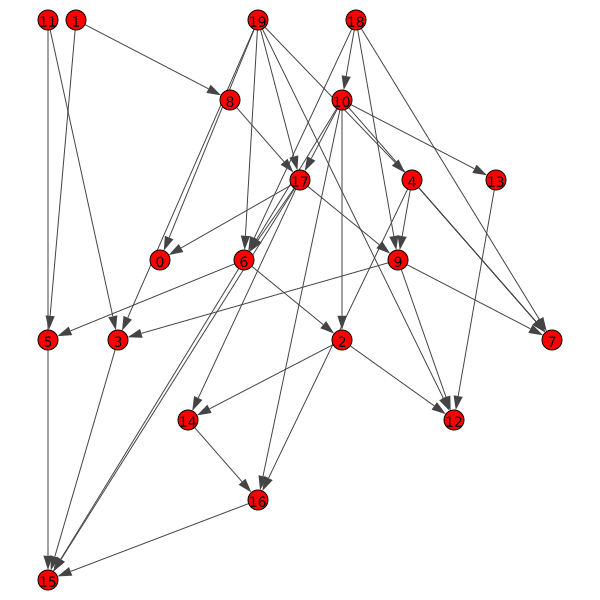

In [34]:
ig.plot(G, vertex_label=np.arange(d), layout="sugiyama")

Text(0.5, 0, 'Topological rank')

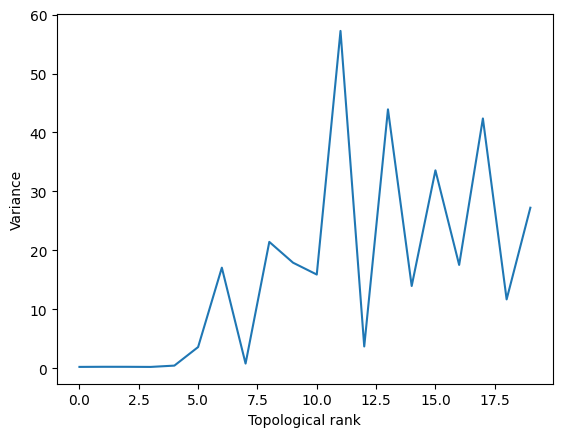

In [35]:
# topo sort
plt.plot(X_obs.var(axis=0)[ordered_vertices])
plt.ylabel("Variance")
plt.xlabel("Topological rank")

Text(0, 0.5, 'Variance(downstream_gene) - Variance(upstream_gene)')

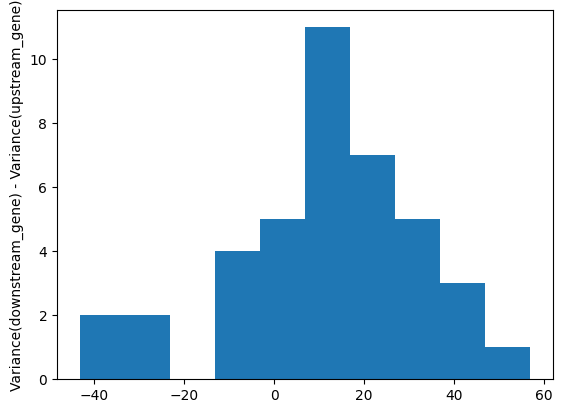

In [36]:
# plot distribution of var diff over true edges (pos means in favored dir)
variances = X_obs.var(axis=0)
var_diffs = []
for i, j in zip(*np.where(B_true)):
    var_diffs.append(variances[j] - variances[i])
plt.hist(var_diffs)
plt.ylabel("Variance(downstream_gene) - Variance(upstream_gene)")

In [37]:
if False:
    # Try SDCI w/ varying perturbation fractions
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using {device}")


    mv_flavor = "nn"
    stage1_kwargs = {
        "n_epochs": 1000,
        "alpha": 1e-2,
        "beta": 1e-4
    }
    stage2_kwargs = {
        "n_epochs": 1000,
        "alpha": 2e-4,
        "beta": 2e-4, 
        "max_gamma": 100
    }

    metrics_df_records = []
    for perturbation_frac in [0, 0.25, 0.5, 0.75, 1.0]:
        n_interventions = int(d * perturbation_frac)
        X_sub_df = subset_interventions(
            X_df, n_interventions, maintain_dataset_size=True
        )
        dataset = create_intervention_dataset(X_sub_df, regime_format=True)

        model = SDCI(model_variance_flavor=mv_flavor)
        model.train(
            dataset,
            B_true=B_true,
            device=device,
            log_wandb=True,
            wandb_project="SDCI_new_sim_frac_test",
            wandb_name=f"SDCI_pf-{perturbation_frac}",
            wandb_config_dict={"model_variance_flavor": mv_flavor, "perturbation_frac": perturbation_frac},
            verbose=False,
            stage1_kwargs=stage1_kwargs,
            stage2_kwargs=stage2_kwargs
        )
        metrics_dict = model.compute_metrics(B_true)
        metrics_dict["mask_recall"] =  (B_true.astype(bool) & model._mask.astype(bool)).sum() / B_true.sum()
        metrics_dict["train_time"] = model._train_runtime_in_sec
        metrics_dict["n_interventions"] = n_interventions
        metrics_df_records.append(metrics_dict)


In [38]:
# metrics_df = pd.DataFrame.from_records(metrics_df_records)
# metrics_df

In [39]:
# metrics_df.sort_values("score")

In [97]:
# inspect obs inferred matrix
mv_flavor = "nn"
stage1_kwargs = {
    "n_epochs": 1000,
    "alpha": 1e-2,
    "beta": 1e-4
}
stage2_kwargs = {
    "learning_rate": 2e-2,
    "n_epochs": 1000,
    "alpha": 2e-5,
    "beta": 2e-5, 
    "max_gamma": 300
}

X_sub_df = subset_interventions(
    X_df, n_interventions = d, maintain_dataset_size=True
)
dataset = create_intervention_dataset(X_sub_df, regime_format=True)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.9, 0.1])

np.random.seed(2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

model = SDCI(model_variance_flavor=mv_flavor, standard_scale=True)
model.train(
    train_dataset,
    B_true=B_true,
    device=device,
    verbose=True,
    log_wandb=True,
    wandb_project="SDCI_small_test",
    wandb_name=f"SDCI",
    stage1_kwargs=stage1_kwargs,
    stage2_kwargs=stage2_kwargs,
    l2_on_dispatcher=False,
)
val_rec_loss = model._model.reconstruction_loss(val_dataset[:][0].to(device), interventions=val_dataset[:][1].to(device)).cpu().detach().item()


Using cuda:0


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=28.36, score=40, shd=40.0, gamma=0.00
Node  0: | | | 16 17 10 7 13 18 19 6 4 5 8 2 3 14 1 9 12 15 11 0
Node  1: | | | 8 5 0 12 17 14 6 7 19 4 11 3 15 13 9 2 10 18 16 1
Node  2: | | | 14 16 18 10 0 7 13 12 19 4 6 17 5 15 1 9 8 3 11 2
Node  3: | | | 9 17 6 5 4 10 19 7 15 18 13 16 0 8 14 11 1 2 12 3
Node  4: | | | 19 9 3 6 5 0 14 17 15 16 2 12 1 18 7 10 13 8 11 4
Node  5: | | | 6 17 9 3 10 7 19 4 13 14 15 0 8 18 16 1 2 12 11 5
Node  6: | | | 5 17 9 3 10 19 7 4 13 0 14 8 15 18 16 1 12 11 2 6
Node  7: | | | 10 18 13 17 16 0 9 6 3 5 2 12 14 15 19 4 8 1 11 7
Node  8: | | | 1 6 12 17 0 14 5 3 9 4 2 19 15 7 11 10 13 16 18 8
Node  9: | | | 3 17 6 5 4 19 7 10 13 18 15 14 16 8 0 2 11 1 12 9
Node 10: | | | 7 17 18 13 16 0 3 9 6 5 2 14 12 15 11 4 19 1 8 10
Node 11: | | | 15 3 6 17 16 2 1 13 8 14 5 9 10 19 12 0 4 7 18 11
Node 12: | | | 2 14 13 8 18 10 16 7 19 1 6 0 9 4 3 15 17 11 5 12
Node 13: | | | 10 7 16 17 18 0 6 9 3 5 12 2 14 15 4 19 11 8 1 13
Node 14: | | | 2 12 19 16 4 6 5 18 10 

Epoch 200: loss=-3.59, score=64, shd=64.0, gamma=0.00
Node  0: 19 17 4 | | 12 6 10 9 2 | 14 7 15 18 11 16 1 8 5 13 3 0
Node  1: 8 5 6 | | 17 3 | 15 9 14 12 10 19 13 16 4 0 7 11 2 18 1
Node  2: 14 6 12 | 19 18 17 9 7 | 10 8 5 0 1 16 15 13 | 11 4 3 2
Node  3: 9 11 19 | 4 15 | 12 0 16 17 14 | 10 6 2 8 18 5 13 7 1 3
Node  4: 19 | 9 | 0 12 | 17 16 13 14 11 3 2 7 18 8 1 15 5 6 10 4
Node  5: 6 1 | 17 | 14 18 | 9 8 10 0 19 7 15 11 3 13 16 12 2 4 5
Node  6: 18 17 19 0 | 5 4 | 12 9 8 1 14 10 2 | 13 3 7 15 11 16 6
Node  7: 10 18 4 9 19 | 17 | 12 0 3 6 | 2 5 16 11 14 13 8 1 15 7
Node  8: 17 1 10 | 5 | 19 9 12 7 2 6 4 18 | 16 3 13 0 11 14 15 8
Node  9: 18 4 17 6 | 19 10 | 3 12 2 5 | 13 16 15 7 8 14 11 1 0 9
Node 10: 18 7 17 | 14 16 | 13 8 2 15 11 19 | 3 1 4 9 0 5 12 6 10
Node 11: 15 16 10 3 | | 9 18 7 | 17 0 4 12 5 8 13 2 6 19 14 1 11
Node 12: 2 19 9 13 14 4 | | 17 3 6 0 18 | 5 10 1 7 11 8 15 16 12
Node 13: 10 | 12 | 2 18 19 | 6 5 0 9 3 7 16 1 15 11 14 8 4 17 13
Node 14: 2 17 | 6 12 0 | 10 18 9 7 1

Epoch 400: loss=-4.92, score=46, shd=46.0, gamma=0.00
Node  0: 19 17 | | 4 6 | 10 9 15 12 7 18 11 2 14 16 1 8 5 13 3 0
Node  1: 8 6 5 | | 10 | 11 17 3 9 0 2 7 13 15 16 4 14 12 18 19 1
Node  2: 14 6 17 10 5 | 19 12 | 18 9 7 1 16 13 0 8 | 4 3 11 15 2
Node  3: 9 11 19 | | 15 4 12 16 | 10 0 17 6 14 8 5 7 2 13 1 18 3
Node  4: 19 | | 9 0 16 | 11 12 7 13 1 17 8 2 15 14 18 10 5 6 3 4
Node  5: 6 1 | | 17 | 14 18 9 7 15 13 10 11 8 0 12 3 19 4 16 2 5
Node  6: 18 19 17 5 | 0 1 | 9 4 8 12 10 14 | 2 3 7 13 11 16 15 6
Node  7: 10 18 4 9 | | 17 19 6 0 | 14 12 3 1 2 13 16 15 8 5 11 7
Node  8: 1 17 10 | | 19 9 5 12 18 7 | 2 16 4 15 14 13 11 3 0 6 8
Node  9: 17 18 4 | 6 | 19 3 12 10 | 2 15 13 16 14 7 1 8 5 11 0 9
Node 10: 18 17 7 | | 16 14 8 13 15 2 11 19 | 3 1 0 9 6 5 4 12 10
Node 11: 15 10 3 16 | 17 | 4 6 | 14 9 0 19 18 5 2 8 13 12 1 7 11
Node 12: 2 19 9 13 | 14 4 | 0 6 10 5 17 | 18 1 8 16 3 7 11 15 12
Node 13: 10 12 19 | | 2 9 18 6 | 5 3 14 11 16 8 4 15 17 1 7 0 13
Node 14: 2 17 | | 0 12 10 | 6 7 9 18

Epoch 600: loss=-5.55, score=43, shd=43.0, gamma=0.00
Node  0: 19 17 | | 6 4 | 15 10 9 11 12 18 7 16 5 2 14 1 8 3 13 0
Node  1: 6 8 5 | | | 10 7 11 9 3 14 4 17 13 12 2 0 16 18 19 15 1
Node  2: 14 6 10 17 | 19 5 12 | 9 8 13 1 18 7 16 | 0 4 3 11 15 2
Node  3: 9 11 19 | | 15 4 16 12 | 10 17 6 7 0 8 5 14 13 1 18 2 3
Node  4: 19 | | 9 0 16 | 11 12 7 13 17 1 14 2 3 18 10 6 15 5 8 4
Node  5: 6 1 | | | 14 17 18 9 15 13 7 0 11 8 10 4 12 3 2 19 16 5
Node  6: 19 18 17 5 | 0 | 1 9 8 4 12 14 10 | 2 3 7 13 11 16 15 6
Node  7: 18 10 4 9 | | 17 6 14 19 | 1 16 2 0 12 3 15 5 8 13 11 7
Node  8: 1 17 10 | | 19 9 12 5 18 7 | 14 16 0 2 13 4 15 11 3 6 8
Node  9: 17 18 4 | | 6 12 3 19 | 10 2 13 16 15 14 5 7 1 8 0 11 9
Node 10: 18 17 7 | | 8 16 14 13 15 11 2 19 | 0 3 1 6 9 5 4 12 10
Node 11: 10 15 3 16 | 17 | 4 6 14 | 19 5 0 8 1 9 7 12 18 2 13 11
Node 12: 2 19 9 13 | | 14 4 6 10 5 | 0 18 17 1 16 8 11 7 15 3 12
Node 13: 10 12 19 | 9 | 2 6 18 14 | 5 11 1 3 4 0 8 15 7 17 16 13
Node 14: 2 17 | | | 6 5 0 1 12 9 16 

Epoch 800: loss=-5.98, score=39, shd=39.0, gamma=0.00
Node  0: 19 17 | | | 4 15 6 10 11 9 7 12 18 16 14 8 2 5 1 3 13 0
Node  1: 6 8 5 | | 7 | 3 10 9 13 14 11 12 4 2 17 18 19 15 0 16 1
Node  2: 14 6 10 17 | 19 12 5 9 | 8 13 7 1 | 18 16 0 4 3 11 15 2
Node  3: 11 9 19 | | 15 4 16 | 12 17 10 6 7 8 13 0 5 18 1 14 2 3
Node  4: 19 | | 9 0 16 | 11 12 7 13 17 14 1 10 8 15 6 18 3 2 5 4
Node  5: 6 1 | | | 14 8 18 15 7 0 13 9 11 17 2 12 4 3 10 16 19 5
Node  6: 19 18 17 5 | | 0 1 9 8 4 10 14 | 12 2 3 7 16 13 11 15 6
Node  7: 18 10 4 9 | | 17 6 19 | 14 16 12 2 5 1 15 3 0 13 8 11 7
Node  8: 1 17 10 | | 19 9 12 5 18 0 | 7 14 2 4 16 13 15 11 3 6 8
Node  9: 17 18 4 | | 6 19 12 3 | 2 14 10 13 16 15 5 7 8 1 0 11 9
Node 10: 18 7 17 | | 8 14 16 15 13 11 19 2 | 0 3 1 6 5 9 12 4 10
Node 11: 10 15 3 16 | 17 | 4 6 14 | 19 5 0 8 9 2 12 1 18 13 7 11
Node 12: 2 19 9 13 | | 4 14 6 | 10 5 17 18 0 11 1 8 16 15 3 7 12
Node 13: 10 12 19 | 9 | 2 6 18 14 | 5 11 0 1 15 16 3 8 17 4 7 13
Node 14: 2 17 | | | 1 5 6 9 0 12 13 

Recall of mask: 1.0
Fraction of possible edges in mask: 0.235
Epoch 0: loss=27.18, score=40, shd=40.0, gamma=0.00
Node  0: | | 19 17 | 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 18
Node  1: | | 5 8 6 | 0 1 2 3 4 7 9 10 11 12 13 14 15 16 17 18 19
Node  2: | | 17 10 19 14 12 5 6 9 | 0 1 2 3 4 7 8 11 13 15 16 18
Node  3: | | 15 11 9 4 19 | 0 1 2 3 5 6 7 8 10 12 13 14 16 17 18
Node  4: | | 19 | 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
Node  5: | | 6 1 | 0 2 3 4 5 7 8 9 10 11 12 13 14 15 16 17 18 19
Node  6: | | 0 5 17 19 18 1 | 2 3 4 6 7 8 9 10 11 12 13 14 15 16
Node  7: | | 10 18 9 4 | 0 1 2 3 5 6 7 8 11 12 13 14 15 16 17 19
Node  8: | | 1 17 9 | 10 19 0 2 3 4 5 6 7 8 11 12 13 14 15 16 18
Node  9: | | 17 4 18 | 0 1 2 3 5 6 7 8 9 10 11 12 13 14 15 16 19
Node 10: | | 7 14 13 18 17 8 | 0 1 2 3 4 5 6 9 10 11 12 15 16 19
Node 11: | | 3 15 4 16 10 | 17 0 1 2 5 6 7 8 9 11 12 13 14 18 19
Node 12: | | 2 19 13 9 | 0 1 3 4 5 6 7 8 10 11 12 14 15 16 17 18
Node 13: | | 2 12 10 9 19 | 0 1 3 4 5 6 7

Epoch 200: loss=7.99, score=26, shd=26.0, gamma=30.03
Node  0: | 17 | 19 | 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 18
Node  1: | | | 8 6 5 0 1 2 3 4 7 9 10 11 12 13 14 15 16 17 18 19
Node  2: | | 14 17 19 6 12 | 9 10 5 0 1 2 3 4 7 8 11 13 15 16 18
Node  3: 9 | 11 4 19 | 15 | 0 1 2 3 5 6 7 8 10 12 13 14 16 17 18
Node  4: | 19 | | 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
Node  5: 1 6 | | | 0 2 3 4 5 7 8 9 10 11 12 13 14 15 16 17 18 19
Node  6: | | 17 5 | 19 18 0 1 2 3 4 6 7 8 9 10 11 12 13 14 15 16
Node  7: 10 18 | 9 | 4 | 0 1 2 3 5 6 7 8 11 12 13 14 15 16 17 19
Node  8: | | 17 10 1 | 19 9 0 2 3 4 5 6 7 8 11 12 13 14 15 16 18
Node  9: | | 4 17 | 18 0 1 2 3 5 6 7 8 9 10 11 12 13 14 15 16 19
Node 10: | | 18 | 17 13 7 14 8 0 1 2 3 4 5 6 9 10 11 12 15 16 19
Node 11: | 15 | 16 10 | 3 17 4 0 1 2 5 6 7 8 9 11 12 13 14 18 19
Node 12: | | 19 2 9 | 13 0 1 3 4 5 6 7 8 10 11 12 14 15 16 17 18
Node 13: | 10 | 9 | 19 12 2 0 1 3 4 5 6 7 8 11 13 14 15 16 17 18
Node 14: | 2 | 17 | 0 1 3 4 5 6 7 8 

Epoch 400: loss=6.46, score=28, shd=28.0, gamma=30.03
Node  0: | | 17 19 | 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 18
Node  1: | | | 8 6 5 0 1 2 3 4 7 9 10 11 12 13 14 15 16 17 18 19
Node  2: | | 14 17 19 | 6 9 12 10 5 0 1 2 3 4 7 8 11 13 15 16 18
Node  3: 9 | 11 4 19 | 15 | 0 1 2 3 5 6 7 8 10 12 13 14 16 17 18
Node  4: | 19 | | 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
Node  5: 1 6 | | | 0 2 3 4 5 7 8 9 10 11 12 13 14 15 16 17 18 19
Node  6: | | 17 5 | 18 19 0 1 2 3 4 6 7 8 9 10 11 12 13 14 15 16
Node  7: 10 18 | 9 | 4 | 0 1 2 3 5 6 7 8 11 12 13 14 15 16 17 19
Node  8: | | 17 10 1 | 19 9 0 2 3 4 5 6 7 8 11 12 13 14 15 16 18
Node  9: | | 4 17 | 18 0 1 2 3 5 6 7 8 9 10 11 12 13 14 15 16 19
Node 10: | | 18 | 17 13 7 14 8 0 1 2 3 4 5 6 9 10 11 12 15 16 19
Node 11: | | 15 16 | 10 3 17 4 0 1 2 5 6 7 8 9 11 12 13 14 18 19
Node 12: | | 19 2 9 | 13 0 1 3 4 5 6 7 8 10 11 12 14 15 16 17 18
Node 13: | | 10 | 9 12 19 2 0 1 3 4 5 6 7 8 11 13 14 15 16 17 18
Node 14: | 2 | | 17 0 1 3 4 5 6 7 8 

Epoch 600: loss=6.01, score=29, shd=29.0, gamma=30.03
Node  0: | | 19 17 | 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 18
Node  1: | | 5 | 6 8 0 1 2 3 4 7 9 10 11 12 13 14 15 16 17 18 19
Node  2: | | 14 19 6 | 17 9 12 10 5 0 1 2 3 4 7 8 11 13 15 16 18
Node  3: 9 | 11 4 19 | 15 | 0 1 2 3 5 6 7 8 10 12 13 14 16 17 18
Node  4: | | 19 | 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
Node  5: 6 1 | | | 0 2 3 4 5 7 8 9 10 11 12 13 14 15 16 17 18 19
Node  6: | | 17 5 | 18 19 0 1 2 3 4 6 7 8 9 10 11 12 13 14 15 16
Node  7: 10 18 | 9 | 4 | 0 1 2 3 5 6 7 8 11 12 13 14 15 16 17 19
Node  8: | | 17 10 | 19 1 9 0 2 3 4 5 6 7 8 11 12 13 14 15 16 18
Node  9: | | 4 17 | 18 0 1 2 3 5 6 7 8 9 10 11 12 13 14 15 16 19
Node 10: | | 18 | 17 7 13 14 8 0 1 2 3 4 5 6 9 10 11 12 15 16 19
Node 11: | | 15 | 10 16 17 3 4 0 1 2 5 6 7 8 9 11 12 13 14 18 19
Node 12: | | 19 2 9 | 13 0 1 3 4 5 6 7 8 10 11 12 14 15 16 17 18
Node 13: | | 10 | 9 12 19 2 0 1 3 4 5 6 7 8 11 13 14 15 16 17 18
Node 14: | 2 | | 17 0 1 3 4 5 6 7 8 

Epoch 800: loss=5.87, score=31, shd=31.0, gamma=30.03
Node  0: | | 17 19 | 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 18
Node  1: | | 5 6 | 8 0 1 2 3 4 7 9 10 11 12 13 14 15 16 17 18 19
Node  2: | | 14 17 | 19 6 12 9 10 5 0 1 2 3 4 7 8 11 13 15 16 18
Node  3: 9 | 11 4 | 19 15 | 0 1 2 3 5 6 7 8 10 12 13 14 16 17 18
Node  4: | | 19 | 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
Node  5: | 6 | 1 | 0 2 3 4 5 7 8 9 10 11 12 13 14 15 16 17 18 19
Node  6: | | 17 5 | 18 19 1 0 2 3 4 6 7 8 9 10 11 12 13 14 15 16
Node  7: 10 18 | 9 | 4 | 0 1 2 3 5 6 7 8 11 12 13 14 15 16 17 19
Node  8: | | 17 10 | 19 1 9 0 2 3 4 5 6 7 8 11 12 13 14 15 16 18
Node  9: | | 4 17 | 18 0 1 2 3 5 6 7 8 9 10 11 12 13 14 15 16 19
Node 10: | | 18 | 17 7 13 14 8 0 1 2 3 4 5 6 9 10 11 12 15 16 19
Node 11: | | 15 | 16 10 17 3 4 0 1 2 5 6 7 8 9 11 12 13 14 18 19
Node 12: | | 2 19 9 | 13 0 1 3 4 5 6 7 8 10 11 12 14 15 16 17 18
Node 13: | | 10 | 12 9 19 2 0 1 3 4 5 6 7 8 11 13 14 15 16 17 18
Node 14: | 2 | | 17 0 1 3 4 5 6 7 8 

Finished training in 28.773638010025024 seconds.


alpha,██████████▁▁▁▁▁▁▁▁▁▁
dag,▁▁▁▁▁▁▁▁▁▁▃█▆▆▅▅▅▄▄▄
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_loss,█▂▁▁▁▁▁▁▁▁█▄▄▄▄▄▃▃▃▃
gamma,▁▁▁▁▁▁▁▁▁▁▁█████████
is_prescreen,██████████▁▁▁▁▁▁▁▁▁▁
l1,▁████▇▇▇▇▇▁▁▁▁▁▁▁▁▁▁
l2,▁▂▃▃▃▄▄▄▅▅▁▃▄▅▅▆▇▇██
n_edges_pred,▁█▇▇▆▆▆▆▆▆▁▂▂▂▂▂▂▂▂▂
nll,█▂▁▁▁▁▁▁▁▁█▄▃▃▃▃▃▃▃▃
precision,▁▄▄▄▅▅▅▅▅▅▁▇███████▇


In [98]:
for name, p in model._model.named_parameters():
    print(name)
    print(torch.sum(p**2).item())

layers.0._weight
4.1546831130981445
layers.0.bias
20.52834701538086
power_grad._dummy_param
0.0
output_layer.weight
3984.0185546875
output_layer.bias
8.458525657653809
var_layer.weight
522.33056640625
var_layer.bias
3.104896068572998


In [99]:
# Plot variance inferred for each gene (this is the intrinsic variance of the gene it should learn)
# plt.plot(model._model.var_activation(model._model.gene_vars).detach().cpu().numpy()[ordered_vertices])
# plt.ylabel("Variance")
# plt.xlabel("Topological rank")

In [100]:
# plt.scatter(model._model.var_activation(model._model.gene_vars).detach().cpu().numpy()[ordered_vertices], X_obs.var(axis=0)[ordered_vertices])

In [111]:
# See how well diff genes are predicted
from utils import TorchStandardScaler
# X = dataset.tensors[0].numpy()
scaler = TorchStandardScaler()
scaled_X = scaler.fit_transform(dataset[:][0]).numpy()
x_m, x_v = model._model(dataset.tensors[0].to("cuda:0"))
x_m, x_v = x_m.cpu().detach().numpy(), x_v.cpu().detach().numpy()

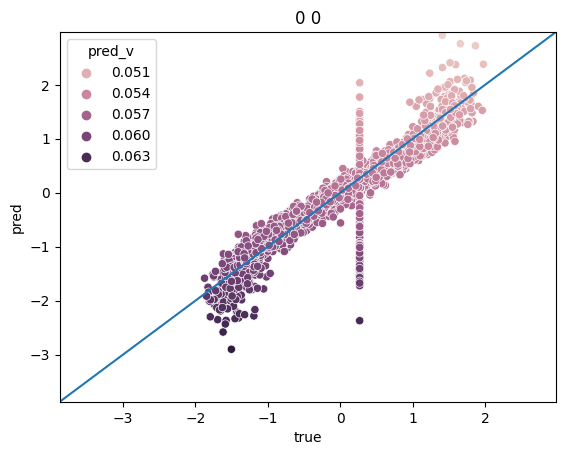

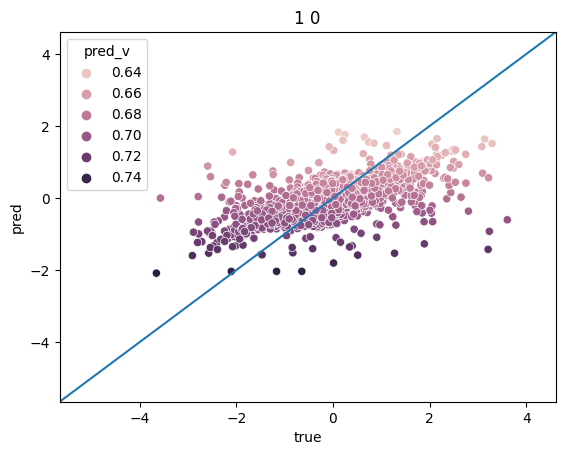

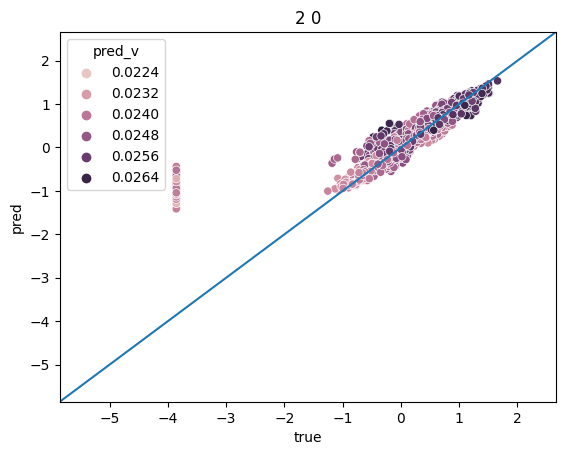

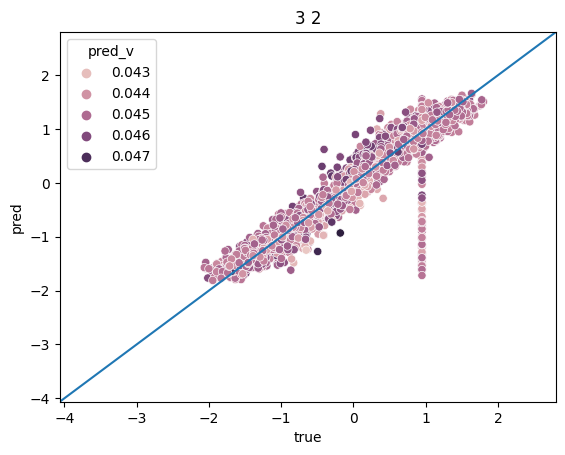

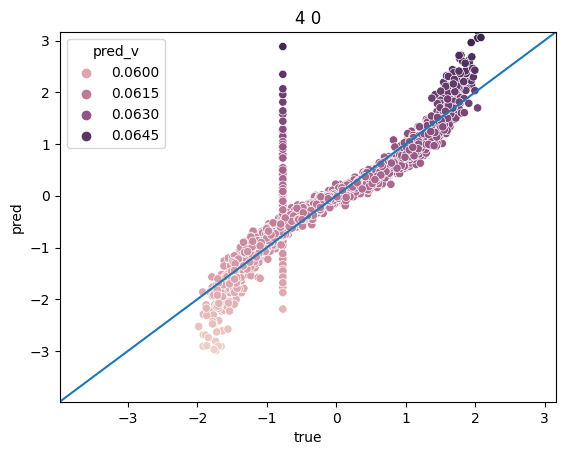

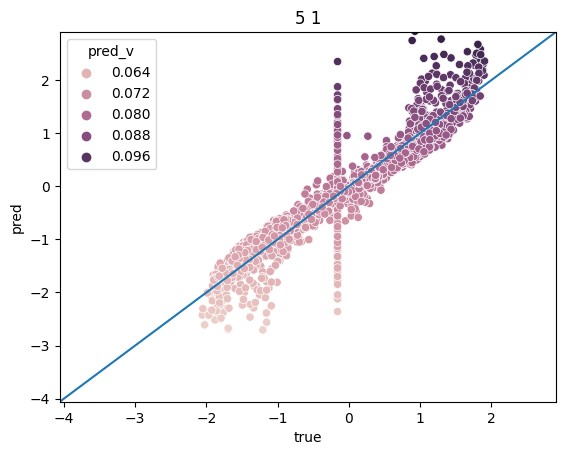

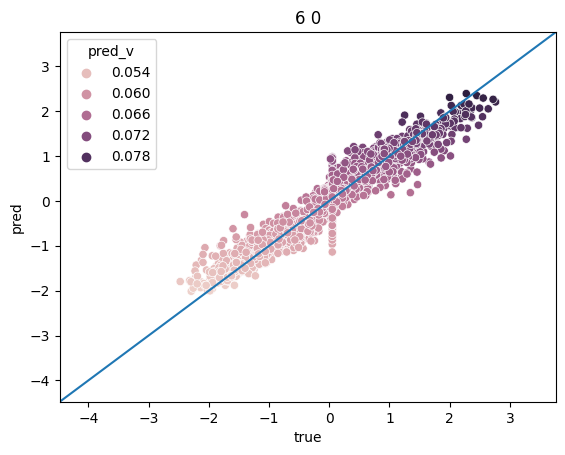

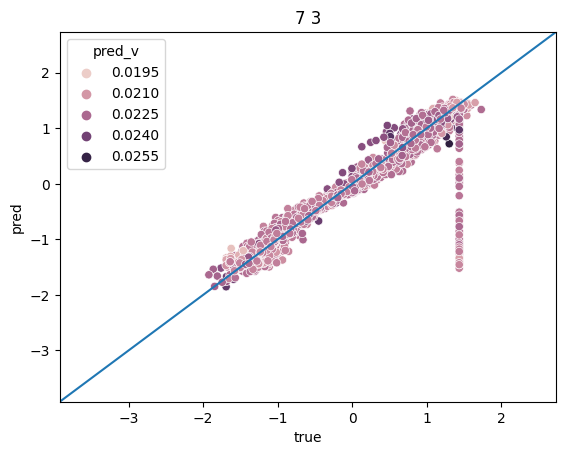

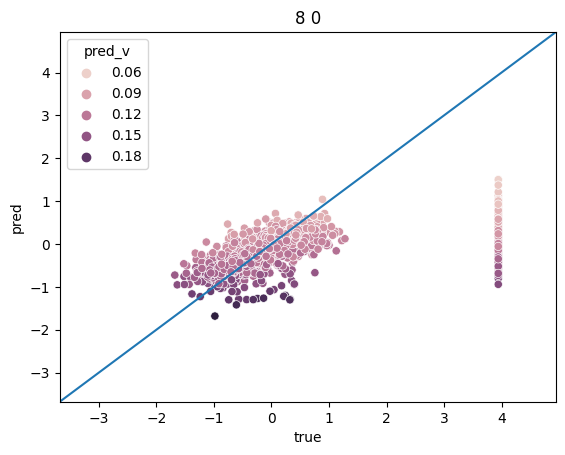

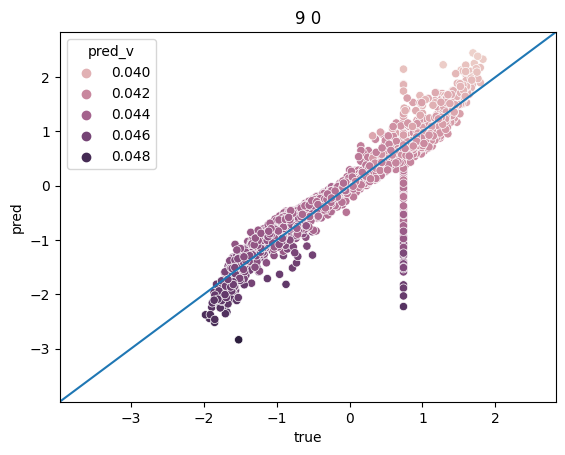

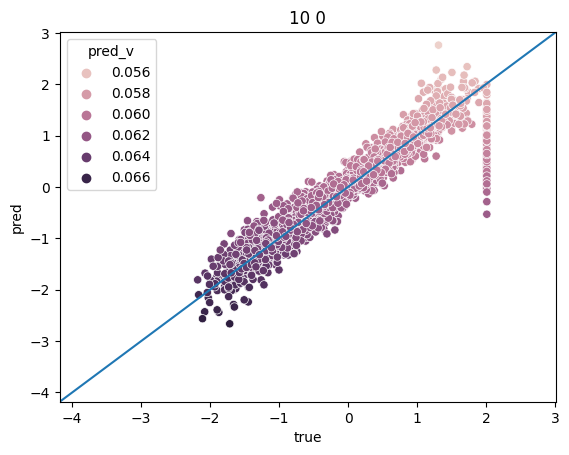

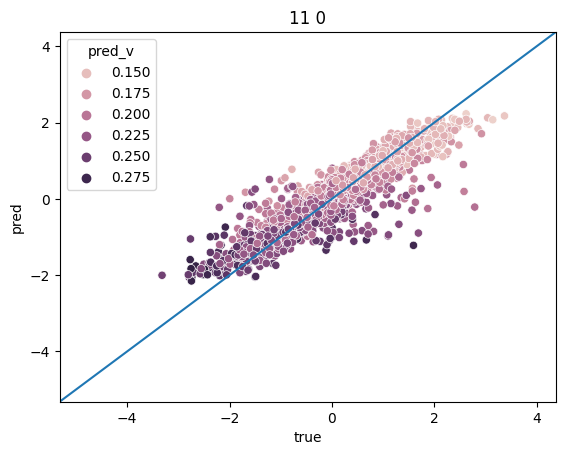

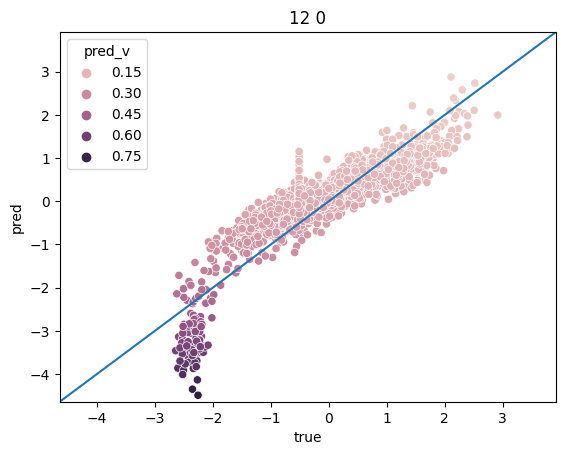

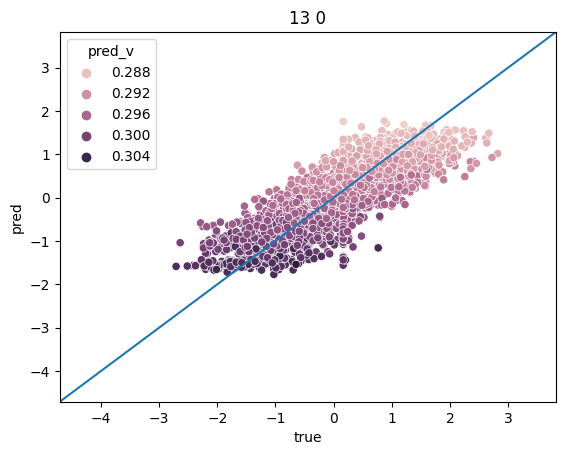

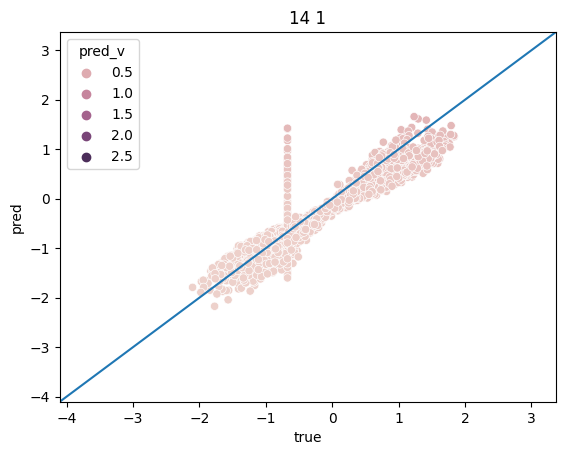

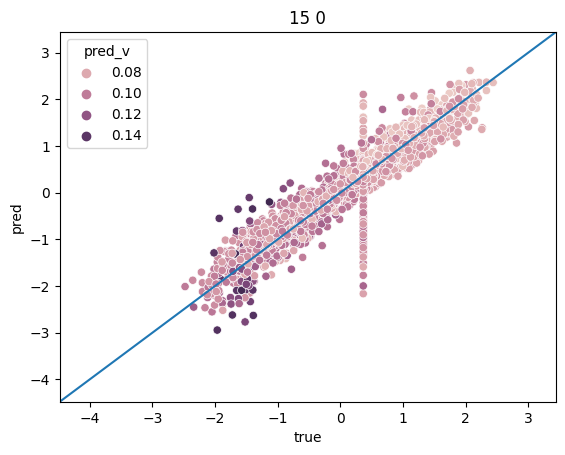

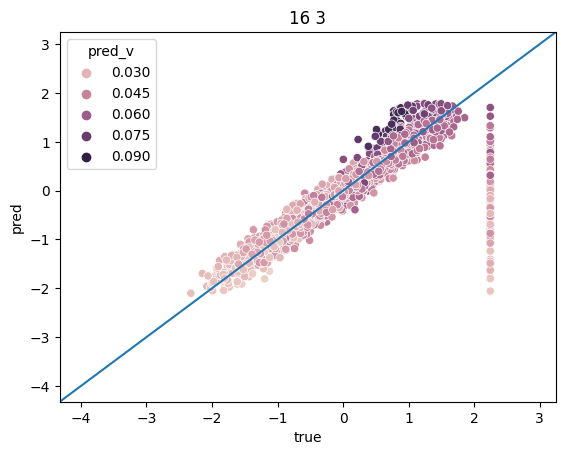

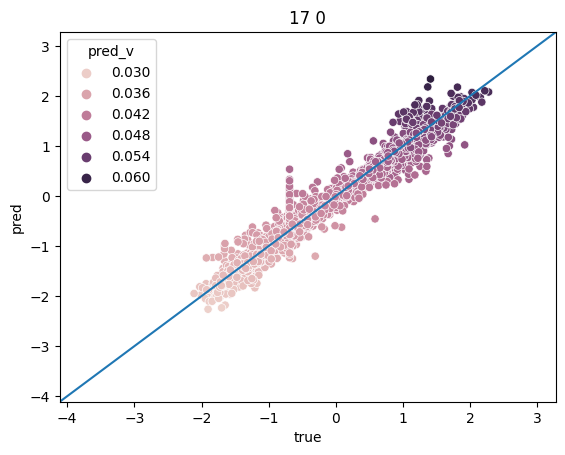

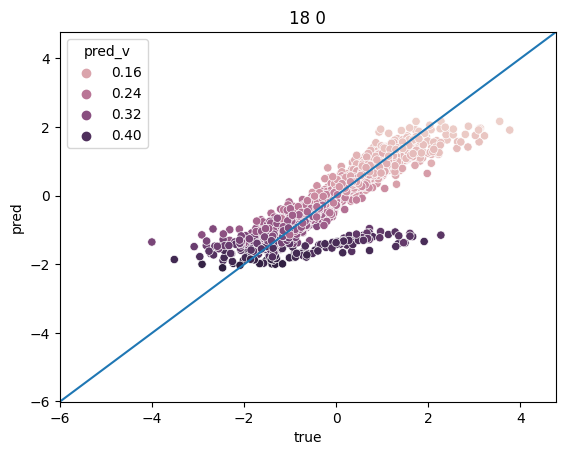

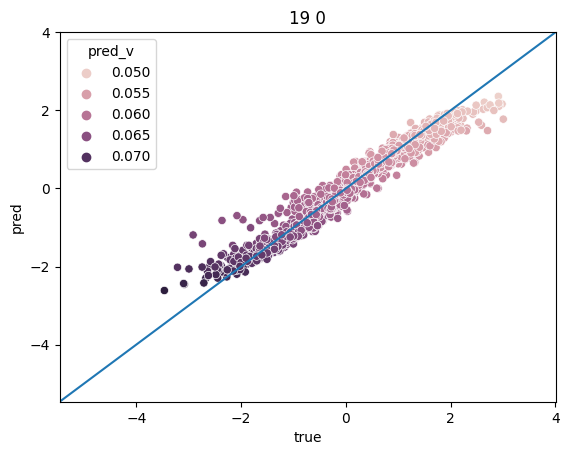

<Figure size 640x480 with 0 Axes>

In [112]:
n_children = model.get_adjacency_matrix().sum(axis=0).tolist()
for gene_idx in range(d):
    p_df = pd.DataFrame(np.vstack((X[:, gene_idx], x_m[:, gene_idx], x_v[:, gene_idx])).T, columns=["true", "pred", "pred_v"])
    x_lim_min = p_df["true"].min() - 2
    x_lim_max = p_df["true"].max() + 1
    sns.scatterplot(p_df.sample(frac=1), x="true", y="pred", hue="pred_v")
    plt.xlim((x_lim_min, x_lim_max))
    plt.ylim((x_lim_min, x_lim_max))
    plt.axline((0, 0), slope=1)
    plt.title(f"{gene_idx} {n_children[gene_idx]}")
    plt.show()
    plt.clf()

In [113]:
for n_p, p in model._model.named_parameters():
    print(n_p)

layers.0._weight
layers.0.bias
power_grad._dummy_param
output_layer.weight
output_layer.bias
var_layer.weight
var_layer.bias


In [114]:
model._model.layers[0]._weight[[10, 12, 18], 13, :]

tensor([[ 7.3038e-02, -5.7615e-04, -4.9009e-02, -5.8814e-02, -6.9141e-02,
          7.6310e-02,  7.5914e-02,  8.4476e-02, -6.9796e-02, -5.6228e-02],
        [ 2.3292e-02, -8.6520e-05, -1.2219e-02, -1.7705e-02, -2.0065e-02,
          2.6794e-02,  2.7436e-02,  2.8107e-02, -2.2931e-02, -1.6697e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],
       device='cuda:0', grad_fn=<IndexBackward0>)

In [115]:
torch.linalg.vector_norm(model._model.layers[0]._weight[:, 2, :], dim=1)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0169, 0.0932, 0.0000, 0.0000,
        0.0683, 0.0168, 0.0000, 0.0821, 0.0000, 0.1481, 0.0000, 0.0000, 0.1007,
        0.0000, 0.0908], device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

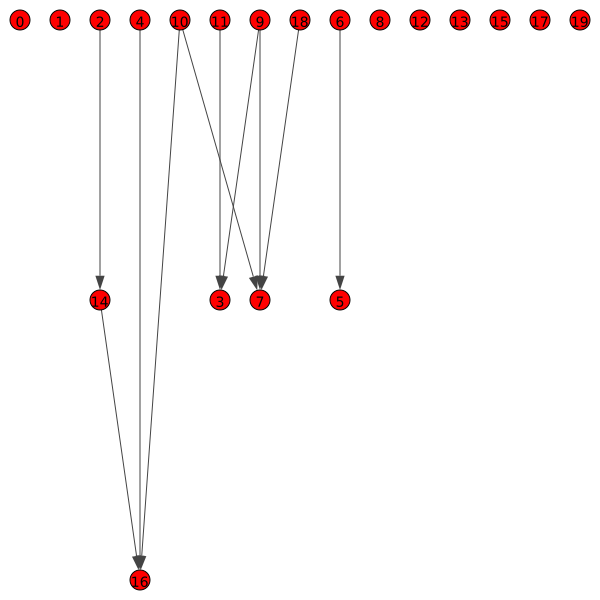

In [116]:
G = ig.Graph.Adjacency(model.get_adjacency_matrix())
ig.plot(G, vertex_label=np.arange(d), layout="sugiyama")

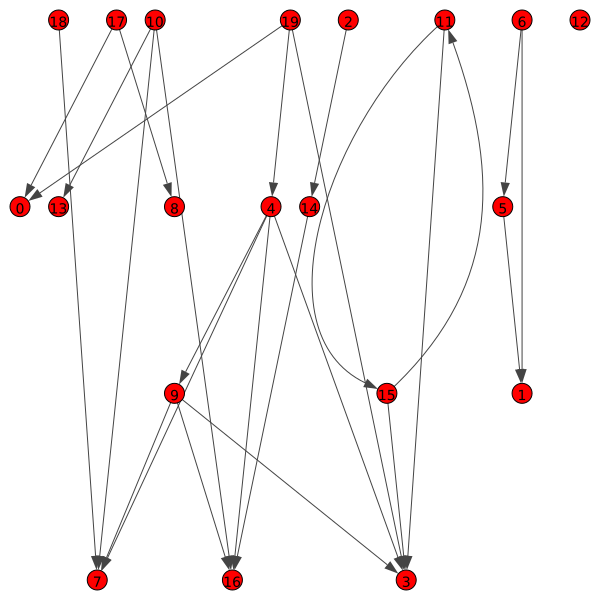

In [117]:
G = ig.Graph.Adjacency(model.get_adjacency_matrix(threshold = False) > 0.2)
ig.plot(G, vertex_label=np.arange(d), layout="sugiyama")

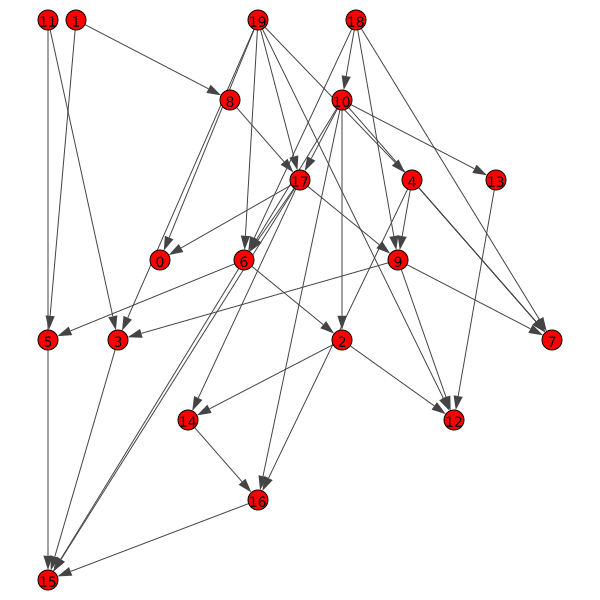

In [118]:
G = ig.Graph.Adjacency(B_true.tolist())
ordered_vertices = G.topological_sorting()
ig.plot(G, vertex_label=np.arange(d), layout="sugiyama")

(-1.9228936433792114, 1.7302439212799072)

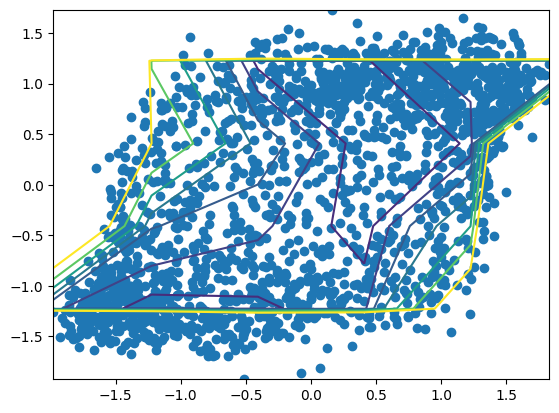

In [119]:
# viz joint dist between an edge
gene_i, gene_j = 9, 7
X_obs = X[~np.isin(dataset.tensors[1].numpy().flatten(), [gene_i, gene_j])]

x_m_obs, x_v_obs = model._model(torch.tensor(X_obs).to(device))
x_m_obs, x_v_obs = x_m_obs.cpu().detach(), x_v_obs.cpu().detach()

xs = np.linspace(-20.0, 20.0)
ys = np.linspace(-20.0, 20.0)
X_mesh, Y_mesh = np.meshgrid(xs, ys)
ll_dist = dist.MixtureSameFamily(dist.Categorical(torch.ones(x_m_obs.shape[0],)), dist.Independent(dist.Normal(x_m_obs[:, [gene_i, gene_j]], x_v_obs[:, [gene_i, gene_j]]), 1))
XX = torch.tensor(np.array([X_mesh.ravel(), Y_mesh.ravel()]).T)
Z = -ll_dist.log_prob(XX)
Z = Z.reshape(X_mesh.shape)
plt.contour(
    X_mesh, Y_mesh, Z, levels=np.logspace(0, 1, 10)
)

X_i = X_obs[:, gene_i]
X_j = X_obs[:, gene_j]
plt.scatter(X_i, X_j)
plt.xlim(X_i.min(), X_i.max())
plt.ylim(X_j.min(), X_j.max())


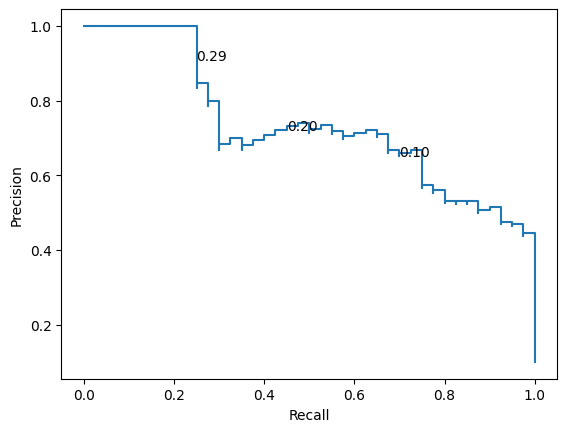

In [120]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

y_test = B_true.astype(bool).reshape(-1)
y_score = model.get_adjacency_matrix(threshold = False).reshape(-1)
prec, recall, vals = precision_recall_curve(y_test, y_score, pos_label=True)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
label_ts = [0.1, 0.2, 0.3]
for label_t in label_ts:
    label_idx = np.argmin(np.abs(vals - label_t))
    plt.text(recall[label_idx], prec[label_idx], f"{vals[label_idx]:.2f}")